In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
from matplotlib import pyplot as plt
import time

# Using mediapipe holistic, full body pose estimation

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks,  mp_holistic.FACEMESH_CONTOURS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [5]:
def draw_custom_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks,  mp_holistic.FACEMESH_CONTOURS,
                             mp_drawing.DrawingSpec(color=(255, 255, 204), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(225, 225, 225), thickness=1, circle_radius=1))
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(255, 0, 255), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(204, 153, 255), thickness=2, circle_radius=2))
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=2, circle_radius=2))
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(0, 128, 0), thickness=2, circle_radius=2),
                             mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2))
    

# Test pose estimation and landmarks drawing

In [136]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    
    while cap.isOpened():
        
        ret, frame = cap.read()
        
        image, results = mediapipe_detection(frame, holistic)
         
        draw_custom_landmarks(image, results)
        
        cv2.imshow("Camera", image)
        
        if cv2.waitKey(10) & 0XFF == ord('q'):
            break
        
cap.release()
cv2.destroyAllWindows()
    

# Get landmarks keypoints from frames

In [6]:
def get_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)

    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
  
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3) 

    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([pose, face, lh, rh])

# Create keypoints data folder

In [7]:
import json

In [8]:
with open('C:/Users/wailb/Downloads/Compressed/archive_2/metadata.json', 'r') as json_file:
    metadata = json.load(json_file)

In [9]:
DATA_PATH = os.path.join('Keypoints_Data')

words = np.array([entry['gloss'] for entry in metadata])

In [10]:
missing_file_path = "C:/Users/wailb/Downloads/Compressed/archive_2/missing.txt" 

missing_IDs = []

with open(missing_file_path, 'r') as file:
    for line in file:
        missing_IDs.append(line.strip())

# Extract keypoints from data

In [ ]:
all_seq = []
i = 0
for entry in metadata:
        
    no_sequences = 0
    sequence_length =  []
    
    for instance in entry["instances"]:
        
        path = "C:/Users/wailb/Downloads/Compressed/archive_2/videos/"
        
        if instance["video_id"] not in missing_IDs:
            no_sequences += 1
            path = path + instance["video_id"] + '.mp4'
            sequence_length.append((instance["video_id"], instance["frame_start"], instance["frame_end"]))
            
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, entry['gloss'], sequence_length[sequence][0]))
        except:
            pass
    all_seq.append((entry['gloss'], no_sequences, sequence_length))
    i += 1
    print(i)
    print(entry['gloss'], '  /  ',no_sequences)


In [11]:
def read_full_video(video_path, action, video_id):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return
    
    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        i = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break 

            image, results = mediapipe_detection(frame, holistic)

            draw_custom_landmarks(image, results)
            
          
            keypoints = get_keypoints(results)
            npy_path = os.path.join(DATA_PATH, action, video_id, str(i))
            
            np.save(npy_path, keypoints)
            i += 1
        print("frames = ",i, video_id)
  
    cap.release()
    cv2.destroyAllWindows()

In [12]:
def read_video_frame_range(video_path, start_frame, end_frame, action, video_id):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
        
        i = 0
        for _ in range(start_frame, end_frame + 1):
            ret, frame = cap.read()
            if not ret:
                break

            image, results = mediapipe_detection(frame, holistic)

            draw_custom_landmarks(image, results)
            
          
            keypoints = get_keypoints(results)
            npy_path = os.path.join(DATA_PATH, action, video_id, str(i))
            
            np.save(npy_path, keypoints)
            
            i += 1
        print("frames = ",i, video_id)
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
action = all_seq[0]
for video in action[2]:
    video_path = "C:/Users/wailb/Downloads/Compressed/archive_2/videos/" + video[0] +'.mp4'
    if video[1] == 1 and video[2] == -1:
        read_full_video(video_path, action[0], video[0])
    else:
        read_video_frame_range(video_path, video[1], video[2], action[0], video[0])
        
    video_path = ""

In [ ]:
i = 0
j = 0
for action in all_seq:
    print(i, ' | ', action[0])
    for video in action[2]:
        video_path = "C:/Users/wailb/Downloads/Compressed/archive_2/videos/" + video[0] +'.mp4'
        if video[1] == 1 and video[2] == -1:
            read_full_video(video_path, action[0], video[0])
        else:
            read_video_frame_range(video_path, video[1], video[2], action[0], video[0])

        video_path = ""
    i += 1


In [ ]:
data = np.array([gloss[0] for gloss in all_seq])
actions = np.array(data[:10])
actions

In [ ]:
sequences, labels = [], []


for gloss in all_seq[:2]:
    for sequence in gloss[2]:
        window = []
        folder_path = os.path.join(DATA_PATH, gloss[0], sequence[0])
        file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        for frame_num in  range(file_count):
            res = np.load(os.path.join(DATA_PATH, gloss[0], sequence[0], "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[gloss[0]])

In [ ]:
minseq = 300
maxseq = 0
for gloss in all_seq[:10]:
    for sequence in gloss[2]:
        window = []
        folder_path = os.path.join(DATA_PATH, gloss[0], sequence[0])
        file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        if file_count < minseq:
            minseq = file_count
        elif file_count > maxseq:
            maxseq = file_count

sequences, labels = [], []


for gloss in all_seq[:10]:
    for sequence in gloss[2]:
        window = []
        folder_path = os.path.join(DATA_PATH, gloss[0], sequence[0])
        file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        for frame_num in  range(minseq):
            res = np.load(os.path.join(DATA_PATH, gloss[0], sequence[0], "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[gloss[0]])

# Create new keypoints dataset 

In [184]:
DATA_PATH = os.path.join('points_Data')

actions = np.array(['hello', 'thank you','w', 'a', 'i', 'l'])
#['##', hello', 'thank you', 'i love you', 'i am', 'w', 'a', 'i', 'l']
no_sequences = 50

sequence_length = 30

In [179]:
for action in actions:
    for sequence in range(50,no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [172]:
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    
    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):
                     
                ret, frame = cap.read()

                image, results = mediapipe_detection(frame, holistic)

                draw_custom_landmarks(image, results)

                
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    
                    cv2.imshow("Camera", image)
                    cv2.waitKey(2000 )
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
                    
                    cv2.imshow("Camera", image)
                
                keypoints = get_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                
        
                if cv2.waitKey(10) & 0XFF == ord('q'):
                    break
        
    cap.release()
    cv2.destroyAllWindows()
    

In [169]:
cap.release()
cv2.destroyAllWindows()

In [182]:
import shutil
import os

In [185]:
for action in actions:
    n_to = no_sequences
    for sequence in range(no_sequences):
        source_folder = os.path.join(DATA_PATH, action, str(sequence))
        destination_folder = os.path.join(DATA_PATH, action, str(n_to))
        for filename in os.listdir(source_folder):
            source_file = os.path.join(source_folder, filename)
            destination_file = os.path.join(destination_folder, filename)
            shutil.copy(source_file, destination_file)
        n_to = n_to + 1

In [121]:

source_folder = '/path/to/source/folder'
destination_folder = '/path/to/destination/folder'

for filename in os.listdir(source_folder):
    source_file = os.path.join(source_folder, filename)
    destination_file = os.path.join(destination_folder, filename)
    shutil.copy(source_file, destination_file)


In [99]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize Holistic model and other variables
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
sequence = []  # Store keypoints for a sequence of frames
threshold = 0.95
sentence = ['...']

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        continue
    
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(image)
    
    # Extract keypoints and add to the sequence
    keypoints = get_keypoints(results)
    sequence.append(keypoints)
    
    # Ensure the sequence has at most 30 frames
    sequence = sequence[-30:]
    
    # Perform prediction if we have 30 frames
    if len(sequence) == 30:
        sequence_for_prediction = np.expand_dims(sequence, axis=0)
        res = model.predict(sequence_for_prediction)[0]
        if res.any() and res[np.argmax(res)].any() > threshold:
            if len(sentence) > 0:
                if actions[np.argmax(res)] != sentence[-1]:
                    sentence.insert(len(sentence)-1, actions[np.argmax(res)])
                    sentence.append('...')
            else:    
                sentence[sentence.index('...')] = actions[np.argmax(res)]
                sentence.append('...')
        if len(sentence) > 7:
            sentence = sentence[-7:]
    
    # Display the sentence on the video frame
    cv2.rectangle(frame, (0, 0), (640, 40), (245, 117, 16), -1)
    cv2.putText(frame, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.imshow("Camera", frame)
    
    if cv2.waitKey(10) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 19ms/step


In [281]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize Holistic model and other variables
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)
sequence = []  # Store keypoints for a sequence of frames
threshold = 0.9
sentence = []
show_dots = True  # Flag to control displaying dots
last_predicted_word = None  # Keep track of the last predicted word

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        continue
    
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(image)
    
    # Extract keypoints and add to the sequence
    keypoints = get_keypoints(results)
    sequence.append(keypoints)
    
    # Ensure the sequence has at most 30 frames
    sequence = sequence[-30:]
    
    # Perform prediction if we have 30 frames
    if len(sequence) == 30:
        sequence_for_prediction = np.expand_dims(sequence, axis=0)
        res = model.predict(sequence_for_prediction)[0]
        if res.any() and res[np.argmax(res)].any() > threshold:
            predicted_word = actions[np.argmax(res)]
            if len(sentence) > 0:
                if predicted_word != sentence[-1]:
                    sentence.append(predicted_word)
                    last_predicted_word = predicted_word
                    show_dots = False  # Set to False when a word is displayed
            else:
                sentence.append(predicted_word)
                last_predicted_word = predicted_word
                show_dots = False  # Set to False when a word is displayed
        else:
            # No prediction, display dots
            show_dots = True
    
    # Display the sentence on the video frame
    cv2.rectangle(frame, (0, 0), (640, 40), (245, 117, 16), -1)
    
    if show_dots:
        cv2.putText(frame, '...', (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    else:
        if last_predicted_word:
            cv2.putText(frame, ''.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    cv2.imshow("Camera", frame)
    
    if cv2.waitKey(10) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 20ms/step


error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - Can't convert object to 'str' for 'text'
>  - Can't convert object to 'str' for 'text'


In [286]:
cap.release()
cv2.destroyAllWindows()


In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Assuming your keypoints have a length of 1662
keypoint_length = 1662
num_classes = 10  # Replace with the actual number of classes

# Flatten sequences into vectors
X = np.array(sequences)  # sequences from your data preparation
X = X.reshape(X.shape[0], -1)  # Flatten each sequence into a single vector

# Convert labels to categorical one-hot encoding
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels).astype(int)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Create and fit a k-NN model
k = 5  # Number of neighbors, adjust as needed
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')


Accuracy: 100.00%


In [48]:
actions[np.argmax(y_pred[5])]

'thank you'

In [49]:
actions[np.argmax(y_test[5])]

'thank you'

In [47]:
y_pred = knn.predict(np.expand_dims(sequence, axis=0))


ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required by KNeighborsClassifier.

C:\Users\wailb\AppData\Local\Temp\ipykernel_18080\1814118434.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis')


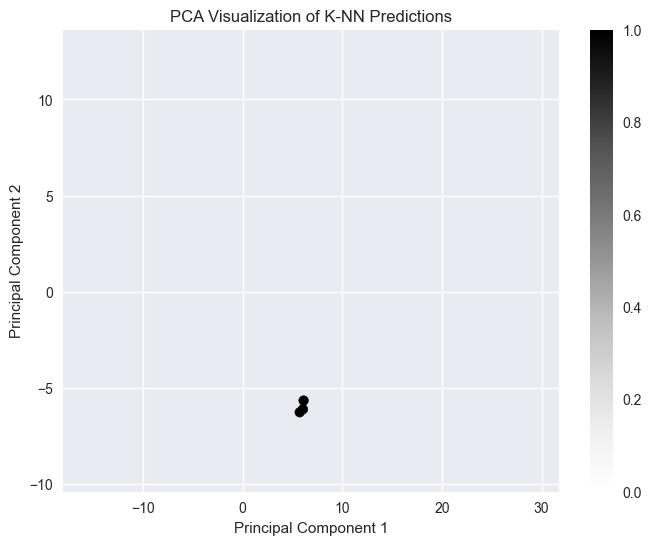